# Widgets

## How do they fit into the picture?

One of the goals of the Jupyter Notebook is to minimize the “distance” the user is from their data.  This means allowing the user to quickly view and manipulate the data.  

| ![](images/inputoutput.PNG)                                                                           | ![](images/widgets.PNG)                                                                                                                      |
|-------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------|
| Before the widgets, this was just the segmentation of code and results from executing those segments. | Widgets further decrease the distance between the user and their data by allowing UI interactions to directly manipulate data in the kernel. |

## How?

Jupyter interactive widgets are interactive elements, think sliders, textboxes, buttons, that have representations both in the kernel (place where code is executed) and the front-end (the Notebook web interface).  To do this, a clean, well abstracted communication layer must exist.

## Comms

This is where Jupyter notebook “comms” come into play.  The comm API is a symmetric, asynchronous, fire and forget style messaging API.  It allows the programmer to send JSON-able blobs between the front-end and the back-end.  The comm API hides the complexity of the webserver, ZMQ, and websockets.

![](images/transport.svg)

## Synchronized state

Using comms, the widget base layer is designed to keep state in sync.  In the kernel, a Widget instance exists.  This Widget instance has a corresponding WidgetModel instance in the front-end.  The Widget and WidgetModel store the same state.  The widget framework ensures both models are kept in sync with eachother.  If the WidgetModel is changed in the front-end, the Widget receives the same change in the kernel.  Vise versa, if the Widget in the kernel is changed, the WidgetModel in the front-end receives the same change.  There is no single source of truth, both models have the same precedence.  Although a notebook has the notion of cells, neither Widget or WidgetModel are bound to any single cell.

![](images/state_sync.svg)

## Views

In order for the user to interact with widgets on a cell by cell basis, the WidgetModels are represented by WidgetViews.  Any single WidgetView is bound to a single cell.  Multiple WidgetViews can be linked to a single WidgetModel.  This is how you can redisplay the same Widget multiple times and it still works.  To accomplish this, the widget framework uses Backbone.js.  In a traditional MVC design, the WidgetModel is the (M)odel, and the WidgetView is both the (V)iew and (C)ontroller. Meaning that, the views both display the state of the model and manipulate it.  Think about a slider control, it both displays the value and allows the user to change the value by dragging the slide handle.

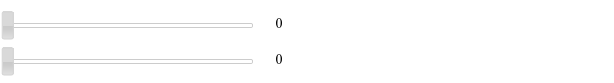

In [1]:
from ipywidgets import *
from IPython.display import display
w = IntSlider()
display(w, w)

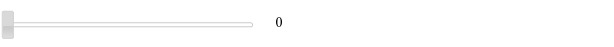

In [2]:
display(w)

![](images/assoc.svg)

## Code execution

The user code required to display a simple FloatSlider widget is:

```python
from ipywidgets import FloatSlider
from IPython.display import display
slider = FloatSlider()
display(slider)
```

In order to understand how a widget is displayed, one must understand how code is executed in the Notebook.  Execution begins in the code cell.  A user event triggers the code cell to send an evaluate code message to the kernel, containing all of the code in the code cell.  This message is given a GUID, which the front-end associates to the code cell, and remembers it (**important**).

![](images/execute.svg)

Once that message is received by the kernel, the kernel immediately sends the front-end an “I’m busy” status message.  The kernel then proceeds to execute the code.

![](images/busy.svg)

## Model construction

When a Widget is constructed in the kernel, the first thing that happens is that a comm is constructed and associated with the widget.  When the comm is constructed, it is given a GUID (globally unique identifier).  A comm-open message is sent to the front-end, with metadata stating that the comm is a widget comm and what the corresponding WidgetModel class is.  

![](images/widgetcomm.svg)

The WidgetModel class is specified my module and name.  Require.js is then used to asynchronously load the WidgetModel class. The message triggers a comm to be created in the front-end with same GUID as the back-end.  Then, the new comm gets passed into the WidgetManager in the front-end, which creates an instance of the WidgetModel class, linked to the comm.  Both the Widget and WidgetModel repurpose the comm GUID as their own.

![](images/widgetcomm2.svg)

Asynchronously, the kernel sends an initial state push, containing all of the initial state of the Widget, to the front-end, immediately after the comm-open message.  This state message may or may not be received by the time the WidgetModel is constructed.  Regardless, the message is cached and gets processed once the WidgetModel has been constructed.  The initial state push is what causes the WidgetModel in the front-end to become in sync with the Widget in the kernel.

![](images/state.svg)

## Displaying a view

After the Widget has been constructed, it can be displayed.  Calling `display(widgetinstance)` causes a specially named repr method in the widget to run.  This method sends a message to the front-end that tells the front-end to construct and display a widget view.  The message is in response to the original code execution message, and the original message’s GUID is stored in the new message’s header.  When the front-end receives the message, it uses the original messsage’s GUID to determine what cell the new view should belong to.  Then, the view is created, using the WidgetView class specified in the WidgetModel’s state.  The same require.js method is used to load the view class.  Once the class is loaded, an instance of it is constructed, displayed in the right cell, and registers listeners for changes of the model.

![](images/display.svg)

## Widget skeleton

In [3]:
%%javascript
this.model.get('count');


this.model.set('count', 999);
this.touch();

/////////////////////////////////

this.colorpicker = $('<input/>');
this.colorpicker.attr('type', 'color');
this.$el.append(this.colorpicker);


<IPython.core.display.Javascript object>

Since widgets exist in both the front-end and kernel, they consist of both Python (if the kernel is IPython) and Javascript code.  A boilerplate widget can be seen below:

Python:
```python
from ipywidgets import DOMWidget
from traitlets import Unicode, Int
 
class MyWidget(DOMWidget):
	_view_module = Unicode('nbextensions/mywidget/mywidget').tag(sync=True)
	_view_name = Unicode('MyWidgetView').tag(sync=True)
	count = Int().tag(sync=True)
```

JavaScript:
```js
define(['jquery', 'jupyter-js-widgets'], function($, widgets) {
	var MyWidgetView = widgets.DOMWidgetView.extend({
    	render: function() {
        	MyWidgetView.__super__.render.apply(this, arguments);
        	this._count_changed();
        	this.listenTo(this.model, 'change:count', this._count_changed, this);
    	},
 
    	_count_changed: function() {
        	var old_value = this.model.previous('count');
        	var new_value = this.model.get('count');
        	$(this.el).text(String(old_value) + ' -> ' + String(new_value));
    	}
	});
 
	return {
    	MyWidgetView: MyWidgetView
	}
});
```

Describing the Python:  

The base widget classes are `DOMWidget` and `Widget`.

`_view_module` and `_view_name` are how the front-end knows what view class to construct for the model.

`sync=True` is what makes the traitlets behave like state.

A similarly named `_model_module` and `_model_name` can be used to specify the corresponding WidgetModel.

`count` is an example of a custom piece of state.

Describing the JavaScript:  

The `define` call asynchronously loads the specified dependencies, and then passes them in as arguments into the callback.  Here both jQuery and the base widget module are loaded.

Custom views inherit from either `DOMWidgetView` or `WidgetView`.

Likewise, custom models inherit from `WidgetModel`.

The `render` method is what is called to render the view’s contents.  If the view is a `DOMWidgetView`, the `.el` attribute contains the DOM element that will be displayed on the page.

`.listenTo` allows the view to listen to properties of the model for changes.

`_count_changed` is an example of a method that could be used to handle model changes.

`this.model` is how the corresponding model can be accessed.

`this.model.previous` will get the previous value of the trait.

`this.model.get` will get the current value of the trait.

`this.model.set` followed by `this.save_changes();` changes the model.  The view method `save_changes` is needed to associate the changes with the current view, thus associating any response messages with the view’s cell.

The dictionary returned is the public members of the module.


## Installation

Because the API of any given widget **must exist in the kernel**, the kernel is the natural place for widgets to be installed.  However, **kernels, as of now, don’t host static assets**.  Instead, static assets are hosted by the webserver, which is the entity that sits between the kernel and the front-end.  This is a problem, because it means widgets have components that need to be **installed both in the webserver and the kernel**.  The kernel components are easy to install, because you can rely on the language’s built in tools.  The static assets for the webserver complicate things, because an extra step is required to let the webserver know where the assets are.

## Static assets

Static assets can be made available to the Jupyter notebook webserver a few ways:
1.       Custom.js: 
By placing your static assets inside the custom directory, alongside custom.js, you can load them within custom.js.  The problem with deployment utilizing this method is that the users will have to manually edit their custom.js file.
2.       Server extension: 
You can write a server extension which adds a new handler to the server that hosts your static content.  However, the server extension needs to be registered using a config file, which means the user needs to edit it by hand.   Also, code needs to be written in custom.js to load the static content.
3.       Nbextension: 
By placing your static assets inside the nbextensions directory, they are made available by the `nbextensions/` handler.  Nbextensions also have a mechanism for running your code on page load.  This can be set using the install-nbextension command.
 
Nbextensions are the best solution, for now, because they can be used without manual user intervention.

## Distribution

Integrating the static assets with the kernel code is tricky.  Ideally, the user would be able to execute a single command to install the package, kernel and static assets included.  Unfortunately, until project Jupyter solves the packaging problem, this isn’t really possible.  The closest thing is `jupyter-pip`, which is designed to execute the install-nbextension command alongside a pip install.  Unfortunately, this method does not work with wheels.

Instead, the best solution for now is to implement a two-step install.  By including an install.py module which calls out to install-nbextension, you can instruct the user to pip install your package and then use python to execute the install script.

An example of what this install.py may look like:
```python
#!/usr/bin/env python
 
# Thanks @takluyver for your cite2c install.py.
# Copyright (c) Jupyter Development Team.
# Distributed under the terms of the Modified BSD License.
 
from __future__ import print_function
 
import argparse
from os.path import dirname, abspath, join as pjoin
 
from notebook.nbextensions import install_nbextension
from notebook.services.config import ConfigManager
 
def install(user=False, symlink=False, enable=False):
	"""Install the widget nbextension and optionally enable it.
	
    Parameters
	----------
	user: bool
    	Install for current user instead of system-wide.
	symlink: bool
    	Symlink instead of copy (for development).
	"""
	staticdir = pjoin(dirname(abspath(__file__)), 'static')
	install_nbextension(staticdir, destination='widgets', user=user, symlink=symlink)
	
    cm = ConfigManager()
    cm.update('notebook', {
        "load_extensions": {
            "widgets/notebook/js/extension": True,
        }
    })

 
if __name__ == '__main__':
 
	parser = argparse.ArgumentParser(description="Installs the Jupyter widgets")
	parser.add_argument("-u", "--user", help="Install as current user instead of system-wide", action="store_true")
	parser.add_argument("-s", "--symlink", help="Symlink instead of copying files", action="store_true")
	args = parser.parse_args()
	
    install(user=args.user, symlink=args.symlink)
```

The code in the ‘__main__’ section is argparser code.  The significant code is within the install function. 

The first line gets the full path to the relative “static” directory, which is home to the static assets of the particular project that this example came from.

`install_nbextension` calls the method that actually installs the static contents into the webserver.

The `ConfigManager` code is what “activates” the extension, causing the specified static assets to be automatically loaded on page load.


## Conclusion

If your package was mywidgets, installation would then be a matter of executing the following two commands:

```
pip install mywidgets
python -m mywidgets.install
```